<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 11. Бустінг
## <center>Частина 2. Порівняння Xgboost і градієнтного бустінга Sklearn</center>

## План

1. [Основні параметри](#1.-Основні-параметри)
2. [Порівняння алгоритмів за часом роботи](#2.-Порівняння-алгоритмів-за-часом-роботи)
3. [Висновки](#3.-Висновки)
4. [Корисні ресурси](#4.-Корисні-ресурси)

## 1. Основні параметри

### XGBoost

Виділяють три групи параметрів:
- Загальні параметри, що відповідають за базовий алгоритм для бустінга і розпаралелювання.
- Параметри обраного базового алгоритму.
- Параметри навчання, що відповідають за функцію втрат і метрику якості на валідації.

**1. Загальні параметри:**
- `booster` [default=gbtree] – тип базового алгоритму для бустінга: дерево рішень gbtree або лінійна модель gblinear.
- `verbosity` [default=1] – повідомлення в процесі роботи алгоритму. Допустимі значення: 0 (silent), 1 (warning), 2 (info), 3 (debug).
- `nthread` [default to maximum number of threads available if not set] – кількість потоків доступних для паралельної роботи xgboost.

**2. Параметри базового алгоритму:**

**2.1. Дерево рішень:**
- `eta` [default=0.3] – швидкість (темп) навчання, перед додаванням дерева в композицію воно множиться на eta. Використовується для запобігання перенавчання за рахунок "скорочення" ваг базових алгоритмів, роблячи модель більш консервативною. Чим менше eta, тим більше потрібно ітерацій `num_boost_round` для навчання моделі з хорошою якістю. Діапазон: [0, 1]
- `gamma` [default=0] – мінімальне зниження значення функції втрат, необхідне для подальшого розбиття вершини дерева. Більші значення gamma > 0 призводять до більш консервативних моделей. Діапазон: [0, $\infty$).
- `max_depth` [default=6] – максимальна глибина дерева. Діапазон: [1, $\infty$).
- `min_child_weight` [default=1] – мінімальна необхідна (зважена) кількість прикладів в кожній вершині. Чим більша, тим більш консервативна кінцева модель. Діапазон: [0, $\infty$).
- `max_delta_step` [default=0] – зазвичай дорівнює нулю. Додатні значення використовуються при незбалансованих класах для прискорення збіжності. Діапазон [0, $\infty$).
- `subsample` [default=1] – частка вибірки, яка використовується для навчання кожного дерева. Якщо subsample < 1, то вибирається випадкова підвибірка, що допомагає в боротьбі з перенавчанням. Діапазон: (0, 1]
- `colsample_bytree` [default=1] – частка ознак, яка використовується для навчання кожного дерева. Діапазон: (0, 1]
- `lambda` [default=1] – коефіцієнт перед $L_2$-регуляризатором в функції втрат.
- `alpha` [default=0] – коефіцієнт перед $L_1$-регуляризатором в функції втрат.

**2.2. Лінійна модель:**
- `lambda` [default=0] – коефіцієнт перед $L_2$-регуляризатором вектора ваг в функції втрат.
- `alpha` [default=0] – коефіцієнт перед $L_1$-регуляризатором вектора ваг в функції втрат.
- `lambda_bias` [default=0] – коефіцієнт перед $L_2$-регуляризатором зсуву (вільного члена) в функції втрат.

**3. Параметри задачі навчання:**
- `objective` [default=reg:linear] – функція втрат, що використовується під час навчання:
    - "reg:linear" – лінійна регресія.
    - "reg:logistic" – логістична регресія.
    - "binary:logistic" – логістична регресія для бінарної класифікації, на виході – ймовірність.
    - "binary:logitraw" – те ж саме, але на виході – значення до його перетворення логістичною функцією.
    - "count:poisson" – регресія Пуассона (використовується для оцінки числа якихось подій, злічена ознака), на виході – математичне сподівання розподілу Пуассона. В цьому випадку `max_delta_step` автоматично встановлюється рівним 0.7.
    - "multi:softmax" – узагальнення логістичної регресії на багатокласовий випадок. При цьому потрібно задати параметр `num_class`.
    - "multi:softprob" – те ж саме, але на виході - вектор розміру ndata * nclass, який можна перетворити в матрицю, що містить ймовірності віднесення даного об'єкта до даного класу.
    - "rank:pairwise" – використовується для задач ранжування.
- `base_score` [default=0.5] – ініціалізація значення моделі для всіх прикладів, глобальний зсув.
- `eval_metric` [default according to objective] – метрика якості на валідаційній вибірці (за замовчуванням відповідає функції втрат: rmse – для регресії, error – для класифікації, mean average precision – для ранжування). Деякі з доступних метрик:
    - "rmse": root mean square error.
    - "logloss": мінус логарифм правдоподібності.
    - "error": частка помилок для бінарної класифікації.
    - "merror": те ж саме для багатокласової класифікації.
    - "mlogloss": logloss для багатокласової класифікації.
    - "auc": AUC.
    - "ndcg": Normalized Discounted Cumulative Gain.
    - "map": Mean average precision.
- `seed` [default=0] – для відтворюваності "випадковості".

**Параметри в xgboost.train**:
- `params` (dict) – параметри, описані вище.
- `dtrain` (DMatrix) – навчальна вибірка.
- `num_boost_round` (int) – кількість ітерацій бустінга.
- `evals` (list) – список для оцінки якості під час навчання.
- `obj` (function) – власна функція втрат.
- `feval` (function) – власна функція для оцінки якості.
- `maximize` (bool) – чи потрібно максимізувати `feval`.
- `early_stopping_rounds` (int) – активує early stopping. Помилка на валідації повинна зменшуватися кожні `early_stopping_ rounds` ітерацій для продовження навчання. Список `evals` повинен бути непорожній. Повертається модель з останньої ітерації. Якщо відбулася рання зупинка, то модель буде містити поля: `bst.best_score` і `bst.best_iteration`.
- `evals_result` (dict) – результати оцінки якості.
- `verbose_eval` (bool) – вивід значення метрики якості на кожній ітерації бустінга.
- `learning_rates` (list or function) – коефіцієнт швидкості навчання для кожної ітерації.
- `xgb_model` (file name of stored xgb model or 'Booster' instance) – можливість продовжити навчання наявної моделі XGB.

## sklearn.ensemble.GradientBoostingClassifier
- `loss` [default="deviance"] – функція втрат, що оптимізується. Одна з {"deviance", "exponential"}. Перша відповідає логістичній регресії і повертає ймовірності, друга – AdaBoost.
- `learning_rate` [default=0.1] – темп навчання, аналогічно `eta` для XGBoost.
- `n_estimators` [default=100] – кількість ітерацій градієнтного бустінга.
- `max_depth` [default=3] – аналогічно `max_depth` для XGBoost.
- `min_samples_split` [default=2] – мінімальна кількість прикладів, необхідна для розгалуження в даній вершині, аналогічно `min_child_weight` для XGBoost.
- `min_samples_leaf` [default=1] – мінімальна кількість прикладів в листку.
- `min_weight_fraction_leaf` [default=0.0] – мінімальна зважена кількість прикладів в листку.
- `subsample` [default=1.0] – аналогічно `subsample` для XGBoost.
- `max_features` (int, float, string or None) [default=None] – кількість (або частка) ознак, що використовуються при розбитті вершини.
    - "auto", тоді max_features=sqrt(n_features).
    - "sqrt", тоді max_features=sqrt(n_features).
    - "log2", тоді max_features=log2(n_features).
    - None, тоді max_features=n_features.
- `max_leaf_nodes` [default=None]
- `init` (BaseEstimator or None) [default=None] – алгоритм для початкових прогнозів.
- `verbose` [default=0] – аналогічно `silent` для XGBoost.
- `warm_start` [default=False] – якщо True, використовується ансамбль з попереднього виклику fit, нові алгоритми додаються до нього, інакше будується новий алгоритм.

## 2. Порівняння алгоритмів за часом роботи

Подивимося на час навчання класифікаторів XGBooster і GradientBoostingClassifier. Для цього будемо генерувати вибірку з 1000 об'єктів і 50 ознак за допомогою sklearn.datasets.make_classification і заміряти час навчання.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm.notebook import tqdm
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

xgb_params1 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'verbosity': 1, 'objective': 'binary:logistic', 'nthread': 1}
xgb_params2 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'verbosity': 1, 'objective': 'binary:logistic', 'nthread': 4}
sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, 
                               n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

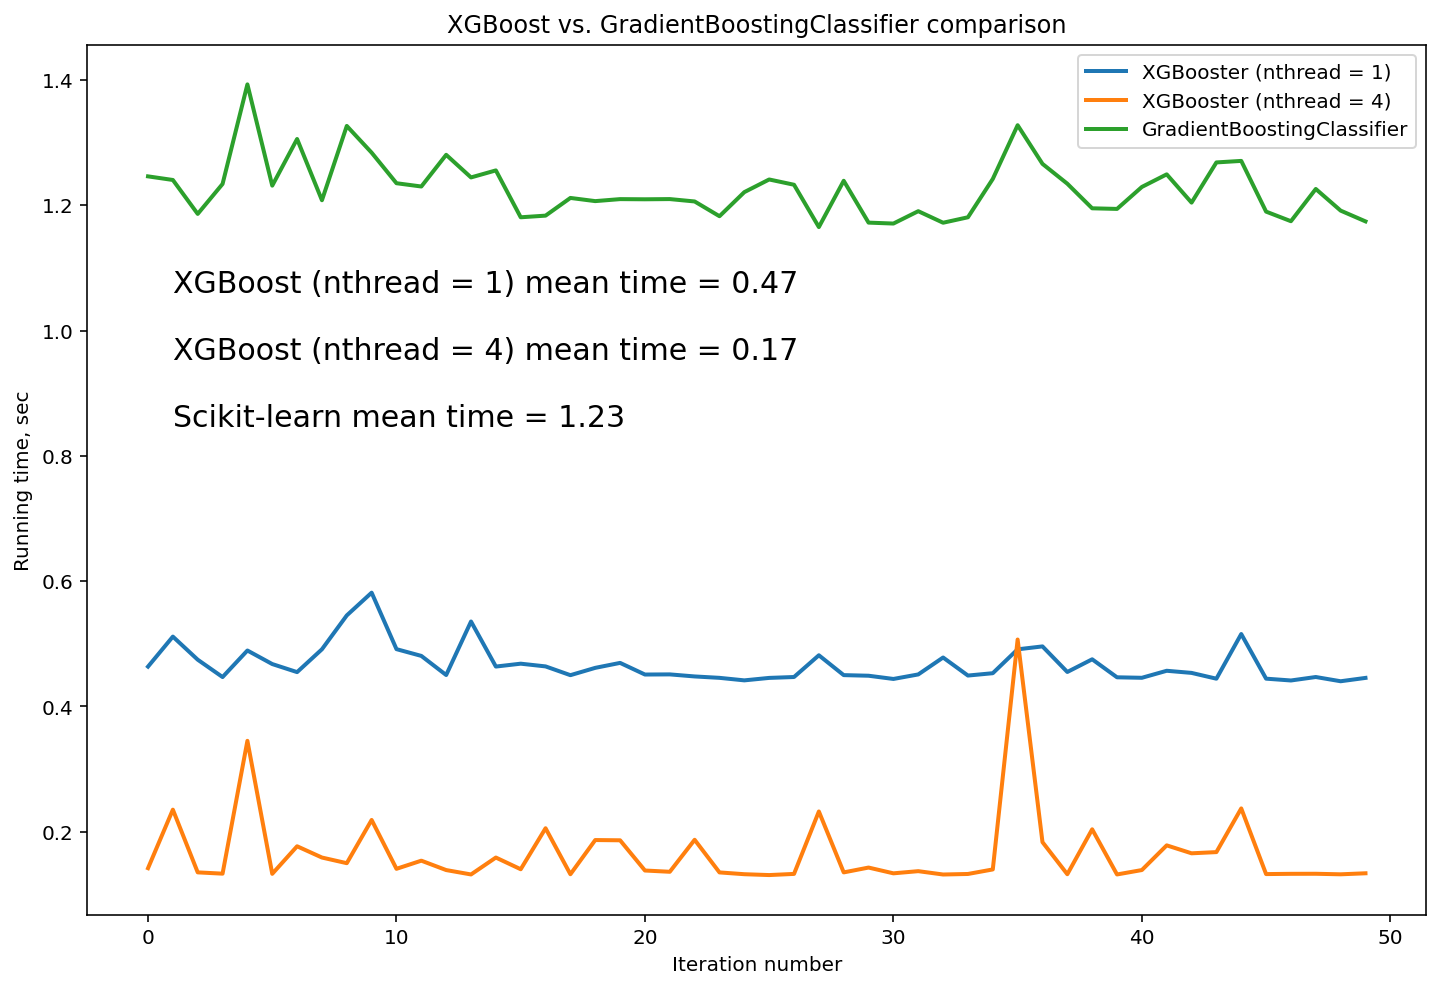

In [2]:
%matplotlib  inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.text(1, (xgb_mean1 + sklearn_mean) / 2, 
         'XGBoost (nthread = 1) mean time = %.2f' % xgb_mean1 +
         '\n\nXGBoost (nthread = 4) mean time = %.2f' % xgb_mean2 +
         '\n\nScikit-learn mean time = %.2f' % sklearn_mean,
            fontsize = 15)
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

## 3. Висновки

Основні переваги XGBoost в порівнянні з sklearn.ensembles.GradientBoostingClassifier:
- Крім дерев можливе використання лінійних моделей в якості базових класифікаторів.
- Швидкість роботи.
- Можливість розпаралелювання.
- Значно більший вибір стандартних функцій втрат, а також можливість задавати свою функцію втрат.
- Наявність регуляризаторів в кінцевій функції втрат і можливість задавати їх коефіцієнти, що дає ще один метод боротьби з перенавчанням, крім використання випадковості (`subsample`, `colsample_bytree`) і основних параметрів дерева рішень.
- Вбудована обробка missing values.

## 4. Корисні ресурси
- [XGBoost](https://xgboost.readthedocs.org/en/latest/parameter.html)
- [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Порівняння](https://github.com/szilard/benchm-ml) різних бібліотек для машинного навчання, в тому числі sklearn і xgboost